# This code is to setup a React Agent Using LangGraph

This code has the following features: 
- It accepts input / question from the user 
- Determine if this contain information about a given Topic (US Related Data)
- IF the question does contain topic related to US, then it should use the knowledgebase stored within Chroma DB (Vector Store) to answer the question. 
- If the topic of the question is not related to US, then it should be answered using LLM
- LLM Used is Gemini

![title](First_Agent.jpg)


## Importing required library

In [15]:
#Importing libraries
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma 
from langchain.text_splitter import RecursiveCharacterTextSplitter

## Load the user data and create a VectorDB and Retriver Object

There the focus is: 
- Read the input context file (text)
- Load them onto a Vector DB (Chroma)
- Build a Retriver Object 
- Also build a function to collect all the document (retrived) into a unified document 

In [16]:
#Define the embedding model 
from langchain_huggingface import HuggingFaceEmbeddings

#Creating Embedding object
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

- BAAI/bge-small-en: Its a Sentence embedding  model by Beijing Academy of AI 
- Embedding size : 384

In [17]:
#Read the input file onto loader object (Directory Loader + Text loader)
loader = DirectoryLoader("../data", glob="./*.txt", loader_cls=TextLoader, show_progress=True)

#Perform Load operation
docs = loader.load()


100%|██████████| 1/1 [00:00<00:00, 447.97it/s]


Here we used DirectoryLoader to read the text file within the directory. Key arguments in DirectoryLoader are 
- Path : Path to the directory 
- glob : What files that we want to read (default all files)
- glob : In out case we are only interested in .txt files, therefore "./.txt" where ./ indicate current directory. 
- loader_cls : Specify the loader to be used to read the selected objects within the directory  
- Snow_Progress: TO see the data loading progress. 

In [18]:
#Splitting the document into chunks 
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200, 
    chunk_overlap=50
)

#Perform Splitting operation 
new_docs = text_splitter.split_documents(documents=docs)

In [19]:
#Input is split into 56 chunks 
len(new_docs)

56

In [30]:
#Creating DB Instance (Chroma)
db = Chroma.from_documents(new_docs, embeddings)

#Creating a retriver object
retriver = db.as_retriever(search_kwargs={"k":3})

- Retriver object is created from Chroma (Vector DB)
- search_kwargs = 3 : We will be getting top 3 values.

In [21]:
#Function to collect the text from the document retrived from retriver so that 
def format_docs(docs):
    return "\n \n".join(doc.page_content for doc in docs)

- Function is responsible for reading the document retrived by the **retriver** object 
- Consolidate them into a single textual document. 

## Building Nodes and Edges based on the solution diagram

### Function 1 : Supervisor Node

- Supervisor Node is responsible to receive the user input. 
- Determine what is the associated **Topic** from the user input 
- Perform necessary steps so that Router can decide which route to take : **LLM Route** or **RAG Route**
- We use an LLM to make the appropriate decision of the topic here. 
- Therefore need to define a **Pydantic** class to define a data model that we expect LLM to return.

Before we jump into Supervisor Nodes we need to Define 2 core components 
1. Pydantic Function
2. AgentStates 

#### PyDantic Function

In [22]:
#Import Pydantic library
from pydantic import BaseModel, Field 

#Defining the Pydantic class 
class TopicSelectionParser(BaseModel):
    Topic : str = Field(description="Identified Topic from user input")
    Reasoning : str = Field(description= "Rationale or Reason for selecting the topic from the user input")

In [23]:
#Attaching the Pydantic Class to Parser output 
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

- In the first step we have created a class inherited from **BaseModel** to define the data model that we want to enforce in the output of LLM. 
- While defining the model, we also explained the **Fields** (Topic & Resoning) that we expect from LLM output and  What is expected to be included in those fields, explained by **Field Description**. 
- Therefore so far we have only created the **Data Model** 
- Next we need an enforcer. Something that can take the Data Model defined and then enforce or ask LLM to follow the structure defined. 
- This is where **PydanticOutputParser** comes in. 
- **PydanticOutputParser** here act as **Translator** and **Structurer** : It is responsible to read the output of LLM and ensure that it enforces the data model defined (by Pydantic)
-- The blueprint in Pydantic Class tell the Parser what kind of data that you expect and what piece of the output data you should be called under the fields  (Topic and Reasoning )
-- The description help the parser and the LLM to understand what information to extract for each of the field. 
-- Eg of Raw Text : "The user wants to talk about 'AI ethics' because they mentioned 'fairness in algorithms'."
-- Topic: AI Ethics 
-- Reasoning : Fairness in algorithms 
- Among all output Parsers available **PydanticOutputParser** is used here to ensure the Reliability, Robustness and better Error Handling. 
- Other Output Parsers are: 
-- StrOutputParser : Simplest of the Parser and it returns the string output from LLM 
-- JsonOutputParser : This parser is good in getting JSON output. 
-- Specialised Parsers : CommaSeparatedListOutputParser, DatetimeOutputParser, XMLOutputParser etc. 
 

#### Agent States

In [24]:
#Defining Agent State
class AgentState(TypedDict): 
    messages : Annotated[Sequence[BaseMessage], operator.add]

- AgentState act as a NoteBook that the Agent uses to keep track of all the converstions / discussions history. 
- AgentState is of type TypedDict. This is a dictionary structure object that enforces specific  **Keys** and **Values**
- In the class we are defining AgentState to be of type **TypedDict**, therefore this class object will have specific keys and values (Defined Template with **slots** or placeholders for capturing the information). 
- *messages* in this case is the placeholder to capture the information in this case historical conversations. 
-- Sequence[BaseMessage] : The message placeholder contain **sequence**  of BaseMessage objects. 
-- **BaseMessage** indicate an entry of conversation (User Question, AI Message etc)
-- operator.add : This implies that we cannot replace and old item in this list, instead we can only **append** the new messages to the end of the existing list.
- In simple terms, AgentState is a special type of data container (like a structured dictionary) specifically designed to hold a sequence of conversational messages. The operator.add part tells the system that when you update this AgentState, new messages should always be added to the end of the existing conversation history, preserving the flow of the conversation.  


#### Model to be used by LLM

In [26]:
#Building the model 
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

-  Gemini model will be used by the model to infer the user question.

#### Function 1 : Supervisor Functional Node

- Function will take the user input 
- Identify the topic based on the structure defined in the prompt 
- Generate output ie Selected Topic and Reasoning. 

In [28]:
#Defining the function (Supervisor) 

def function_1(state: AgentState):
    
    #Identify the node that executes the task 
    print("------> Supervisor <-----------")
    
    #Capturing the user question 
    #Taking the last message as the recent user question 
    question = state["messages"][-1] 
    
    #Display the question 
    print("Question is : ", question)
    
    #Next is to define the input to the LLM. 
    template = """ 
    Your task is to clarify if the given user query into the following categories : [USA, Not Related].
    Only respond with the Category Name and Nothing else. 
    
    User question : {question}
    
    {format_instructions}
     
    """
    
    #Creating Prompt for LLM 
    prompt = PromptTemplate(
        template=template, 
        input_variables=["question"],
        partial_variables={"format_instructions":parser.get_format_instructions()}
    )
    
    #Creating the chain 
    chain = prompt | model | parser 
    
    #Executing the Chain 
    response = chain.invoke({"question : ", question })
    
    #Display the response 
    print("Parsed response from Supervisor : ", response)
    
    #Returning state 
    return{"messages" : [response.Topic]}  


### Function 2 : RAG 

- Function will take the user input 
- Check in the vector DB for relevant answers 
- Produce output based on the context captured within the vectorDB

In [33]:
#RAG Function : Function 2 
def function_2(state: AgentState):
    
    #Identify the node that performs the execution 
    print("============> RAG Node <======================")
    
    #Identifying the user question as the fist message
    question = state["messages"][0]
    
    #Defining the Prompt to execute 
    prompt = PromptTemplate(
        
        #Defining a RAG Template
        template= """ 
        You are an assistant for answering the given question and provide accurate answers. 
        Use the following pieces retrieved from the context to answer the question. 
        If you dont know the answer, then you just say that you dont know the answer. 
        Use a maximum of three sentences to answer the question.
        
        \n 
        Question : {question} 
        
        \n
        Context : {context}
        
        \n
        Answer : 
        """ ,
        input_variables=['context', 'question']
    )
    
    #Building the RAG Chain 
    rag_chain = (
        {"context": retriver | format_docs, "question": RunnablePassthrough()}
        |   prompt 
        |   model 
        |   StrOutputParser()     
    )

    #Generating Result 
    result = rag_chain.invoke(question)

    #Return message
    return {"messages": [result]}
    

#### LLM Call : Function 3

- In this function we use the input from the user 
- Generate output from LLM based on user query.

In [34]:
#LLM Call 
def function_3(state: AgentState):
    
    #Identifying the node that is executing 
    print("===========> LLM Call <=====================")
    
    #Getting the user question 
    question = state["messages"][0]
    
    #User question is passed onto the model to get the response 
    complete_query = "Answer the following question with your knowledge of the reason world. The question is  " + question 
    
    #Generating LLM Response 
    response = model.invoke(complete_query)
    
    #Result from LLM 
    return{"messages": [response.content]}

#### Building a Router 

- **Router** is responsible to pass the control to RAG or LLM based on the type of Topic. 
- If the user topic to determined by **Supervisor** to determine if we need to use RAG Path or LLM Path. 

In [36]:
#Here we define the router function 
def router(state: AgentState):
    
    #Identifying the node we are in 
    print("====================> Router <================")
    
    #Fetching the last message (output from Supervisor )
    last_message = state["messages"][-1]
    
    #Display the last message 
    print("Messaged received to Router ", last_message)
    
    #Establishing the Routing Rules 
    if "usa" in last_message.lower(): 
        return "RAG Call"
    else: 
        return "LLM Call"

## Building Workflow 

- Here we build orchestration framework for the workflow.  

In [40]:
#We will be building the Orchestration workflow 
#Importing the required libraries 
from langgraph.graph import StateGraph, END 

#Creating the StateGrapth object aka workflow 
workflow = StateGraph(AgentState)

#Adding Nodes 
workflow.add_node("Supervisor", function_1) #Naming Function 1 as Node Supervisor 
workflow.add_node("RAG", function_2) #Naming Function 2 as Node RAG 
workflow.add_node("LLM", function_3) #Naming Function 3 as Node LLM 

#Specifying the beginning node (to which input will go to)
workflow.set_entry_point("Supervisor")

#Defining the conditional Edges 
workflow.add_conditional_edges(
    "Supervisor", #Intial Node to accept the input 
    router, #Supervisor output will go to router 
    {
        "RAG Call" : "RAG", #Deligate to RAG 
        "LLM Call" : "LLM" #Deligate to LLM 
    }
)

#Adding Nodes Edge 
workflow.add_edge("RAG", END)
workflow.add_edge("LLM", END)

#Compile the workflow to create the app 
app=workflow.compile()

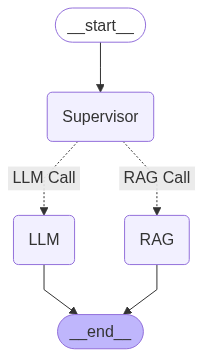

In [41]:
#Display the workflow 
workflow.compile()

#### Executing the workflow 

In [43]:
#Creating input 
state={"messages":["What is the Population of Singapore? "]}

#Executing the app 
app.invoke(state)

------> Supervisor <-----------
Question is :  What is the Population of Singapore? 
Parsed response from Supervisor :  Topic='Not Related' Reasoning='The question is about the population of Singapore, which is not related to the USA.'
====================> Router <================
Messaged received to Router  Not Related
===========> LLM Call <=====================


{'messages': ['What is the Population of Singapore? ',
  'Not Related',
  'The population of Singapore is not a static number and fluctuates.  However, according to the latest readily available data (which can vary slightly depending on the source and the exact date of the data collection), the population of Singapore is approximately **5.7 to 5.9 million people**.  To get the most precise current figure, you should consult official Singaporean government statistics websites.']}